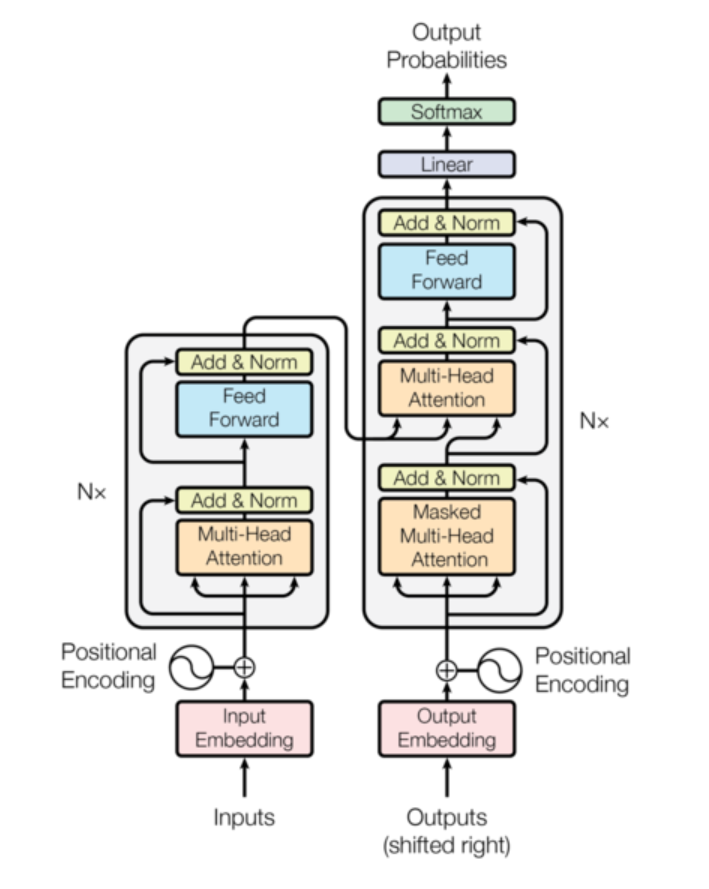

In [11]:
import numpy as np
import math, copy
import torch
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import Image, display

Image("images/encoderDecoder.PNG", width=300)

In [12]:

class EmbedEncode(nn.Module):
    "also multiply the weights by sqrt(d_model) after embedding according to the paper"
    def __init__(self, d_model=512, d_input=1024, max_seq_len=512):
        super(EmbedEncode, self).__init__()
        self.d_model = d_model
        self.d_input = d_input
        self.max_seq_len = max_seq_len
        self.embedding = nn.Embedding(d_input, d_model)

    def forward(self, x):
        # x can be [batch, seq_len, d_input]
        # e.g. "say hello to world" 1x4x1024

        # 1. Add pads                    # 1x4x1024
        x = self.add_pads(x)             # 1x512x1024

        # 2. Embedding
        x = self.embedding(x)            # 1x512x512
        x = x * math.sqrt(self.d_model)  # 1x512x512

        # 3. Position Encoding
        x = self.pos_encoding(x)         # 1x512x512
        return x

    def add_pads(self, x):
        # add pads to [B x max_seq_len x d_input]
        if x.size()[1] < self.max_seq_len:
            B, S, _ = x.size()
            pads = torch.zeros([B, self.max_seq_len-S, self.d_input])
            pads[:, :, -1] = 1
            x = torch.cat([x, pads], -2)
        return x
    
    def pos_encoding(self, x):
        "PE (pos, 2i)   = sin(pos / 10000^(2i/d_model))" # position is word pos in sequence
        "PE (pos, 2i+1) = cos(pos / 10000^(2i/d_model))" # i is index in d_model
        B, _, _ = x.size() # 1x512x512
        even_i = torch.arange(0, self.d_model, 2).float()                      # 256 (d_model / 2)
        denominator = torch.pow(even_i, (even_i / self.d_model))               # 256 (d_model / 2)
        position = torch.arange(self.max_seq_len).reshape(self.max_seq_len, 1) # 512x1 (seq_len x 1)

        even_PE = torch.sin(position / denominator)                            # 512x256 (seq_len x (d_model/2))
        odd_PE  = torch.cos(position / denominator)                            # 512x256 (seq_len x (d_model/2))

        stacked = torch.stack([even_PE, odd_PE], dim=-1)                       # 512x256x2 (seq_len x (d_model/2) x 2)
        pe = torch.flatten(stacked, start_dim=-2, end_dim=-1)                  # 512x512 (seq_len x d_model) [[even_0 odd_0 even_1 odd_1...]...]
        batch_pe = pe.unsqueeze(0).repeat(B, 1, 1)                             # 1x512x512
        x = x + batch_pe                                                       # 1x512x512
        return x




In [13]:
class LayerNorm(nn.Module):
    "Layer Norm is across batch? (d_batch x d_model)"
    def __init__(self, d_model=512, d_batch=1, eps=1e-5):
        self.eps=eps
        self.d_model = d_model
        self.d_batch = d_batch
        self.gamma = nn.Parameter(torch.ones(d_batch, d_model))
        self.beta =  nn.Parameter(torch.zeros(d_batch, d_model))

    def forward(self, x):
        B, _, _ = x.size()               # 1x512x512 (d_batch, seq_len, d_model)
        x = x.permute(1, 0, 2)           # 512x1x512 (seq_len, d_batch, d_model)
        mean = x.mean(-1).mean(-1)       # 512 (seq_len)

        diff = torch.empty(x.size())     # 512x1x512
        for i in range(x.size()[0]):
            diff[i] = (x[i] - mean[i]) ** 2
        
        var = diff.mean(-1).mean(-1)     # 512 (seq_len)
        std = (var + self.eps).sqrt()    # 512 (seq_len)

        y = torch.empty(x.size())        # 512x1x512
        for i in range(x.size()[0]):
            y[i] = (x[i] - mean[i]) / std[i]

        y = y.permute(1, 0, 2)           # 1x512x512 (d_batch, seq_len, d_model) revert the shape

        out = y * self.gamma + self.beta # 1x512x512 (d_batch, seq_len, d_model)
        return out


In [14]:
class MultiHeadAttention(nn.Module):
    "take x but linear maps to q k v"
    "also linear maps the output at the end"
    def __init__(self, d_model=512, max_seq_len=512, num_heads=8):
        self.d_model = d_model
        self.max_seq_len = max_seq_len
        self.num_heads = num_heads
        self.d_head = d_model // num_heads
        self.linearQ  = nn.Linear(d_model, 1*d_model) # 1x512x512 -> 1x512x512
        self.linearKV = nn.Linear(d_model, 2*d_model) # 1x512x512 -> 1x512x1024
        self.linearOut = nn.Linear(d_model, d_model) # do linear mapping at the end

    def forward(self, x, m=None, decoderMask=False):
        B, S, M =  x.size()                                                   # 1x512x512 (d_batch, seq_len, d_model)
        # m has the same size as x if not None
        q_ = self.linearQ(x)                                                  # 1x512x512  (d_batch, seq_len, 1 x d_model)
        kv_ = self.linearKV(x) if m is None else self.linearKV(m)             # 1x512x1024 (d_batch, seq_len, 2 x d_model)

        qkv = torch.cat([q_, kv_], -1)                                        # 1x512x1536 (d_batch, seq_len, 3 x d_model)
        
        qkv = qkv.reshape(B, S, self.num_heads, 3 * self.d_head)              # 1x512x8x192 (d_batch, seq_len, num_heads, 3 x d_head) d_head is 64
        qkv = qkv.permute(2, 1, 0, 3)                                         # 8x512x1x192 (num_heads, seq_len, d_batch, 3 x d_head)

        q, k, v = qkv.chunk(3, dim=-1)                                     # Q: 8x512x1x64 (num_heads, seq_len, d_batch, d_head)
        
        next_v, _ = self.scaled_dot_product(q, k, v, decoderMask)             # 8x512x1x192 (num_heads, seq_len, d_batch, 3 x d_head)

        next_v = next_v.permute(2, 1, 0, 3)                                   # 1x512x8x64 (d_batch, seq_len, num_heads, d_head)
        next_v = next_v.reshape(self.d_batch, self.max_seq_len, self.d_model) # 1x512x512 (d_batch, seq_len, d_model)

        out = self.linearOut(next_v)                                          # 1x512x512 (d_batch, seq_len, d_model)
        return out

    def scaled_dot_product(self, q, k, v, decoderMask=False):
        d_q = q.size()[-1]                                             # 64 (d_head)
        scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_q) # 8x512x64x64 (num_heads, seq_len, d_head, d_head)
        # 8x512x1x64 dot (8x512x1x64)^T = 8x512x64x64

        if decoderMask:
            scaled = scaled + self.make_mask(scaled.size())            # 8x512x64x64
        
        attention = F.softmax(scaled, dim=-1)                          # 8x512x64x64
        values = torch.matmul(attention, v)                            # 8x512x1x64 ( 8x512x64x64 dot 8x512x1x64 = 8x512x1x64)
        return values, attention
    
    def make_mask(self, size):
        mask = torch.full(size, float('-inf'))                         # 8x512x64x64
        mask = torch.triu(mask, diagonal=1)                            # 8x512x64x64
        return mask

    

In [15]:
class FeedForward(nn.Module):
    def __init__(self, d_model=512, d_hidden=1024, max_seq_len=512, dropout=0.1):
        self.d_model = d_model
        self.d_hidden = d_hidden
        self.max_seq_len = max_seq_len
        self.dropout = dropout
        self.linear1 = nn.Linear(d_model, d_hidden)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_hidden, d_model)

    def forward(self, x):
        #                     1x512x512  (d_batch, seq_len, d_model)
        x = self.linear1(x) # 1x512x1024 (d_batch, seq_len, d_hidden)
        x = F.relu(x)       # 1x512x1024 (d_batch, seq_len, d_hidden)
        x = self.dropout(x) # 1x512x1024 (d_batch, seq_len, d_hidden)
        x = self.linear2(x) # 1x512x512  (d_batch, seq_len, d_model)
        return x

In [16]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model=512, max_seq_len=512, d_batch=1, num_heads=8):
        super(EncoderLayer, self).__init__()
        self.multiHeadAttn = MultiHeadAttention(d_model=d_model, max_seq_len=max_seq_len, num_heads=num_heads) # 1x512x512 -> 1x512x512
        self.norm1 = LayerNorm(d_model=d_model, d_batch=d_batch)                                               # 1x512x512 -> 1x512x512
        self.feedForward = FeedForward(d_model=d_model, max_seq_len=max_seq_len)                               # 1x512x512 -> 1x512x512
        self.norm2 = LayerNorm(d_model=d_model, d_batch=d_batch)                                               # 1x512x512 -> 1x512x512

    def forward(self, x):
        #                           1x512x512
        y = self.multiHeadAttn(x) # 1x512x512
        y = x + y        # Residual 1x512x512
        y = self.norm1(y)         # 1x512x512
        z = self.feedForward(y)   # 1x512x512
        z = y + z        # Residual 1x512x512
        z = self.norm2(z)         # 1x512x512
        return z


In [17]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model=512, max_seq_len=512, d_batch=1, num_heads=8):
        super(EncoderLayer, self).__init__()
        self.multiHeadAttn1 = MultiHeadAttention(d_model=d_model, max_seq_len=max_seq_len, num_heads=num_heads) # 1x512x512 -> 1x512x512
        self.norm1 = LayerNorm(d_model=d_model, d_batch=d_batch)                                                # 1x512x512 -> 1x512x512
        self.multiHeadAttn2 = MultiHeadAttention(d_model=d_model, max_seq_len=max_seq_len, num_heads=num_heads) # 1x512x512, 1x512x512 -> 1x512x512
        self.norm2 = LayerNorm(d_model=d_model, d_batch=d_batch)                                                # 1x512x512 -> 1x512x512
        self.feedForward = FeedForward(d_model=d_model, max_seq_len=max_seq_len)                                # 1x512x512 -> 1x512x512
        self.norm3 = LayerNorm(d_model=d_model, d_batch=d_batch)                                                # 1x512x512 -> 1x512x512

    def forward(self, x, m):
        #                                                x: 1x512x512 m: 1x512x512
        y = self.multiHeadAttn1(x)                        # 1x512x512
        y = x + y                                # Residual 1x512x512
        y = self.norm1(y)                                 # 1x512x512
        z = self.multiHeadAttn2(y, m=m, decoderMask=True) # 1x512x512, 1x512x512 -> 1x512x512
        z = y + z                                # Residual 1x512x512
        z = self.norm2(z)                                 # 1x512x512
        w = self.feedForward(z)                           # 1x512x512
        w = z + w                                         # 1x512x512
        w = self.norm3(w)                                 # 1x512x512
        return w

In [18]:
class Input2Encode(nn.Module):
    "Flow from inputs to N layers of encoder"
    def __init__(self, d_model=512, d_input=1024, max_seq_len=512, d_batch=1, N=6, num_heads=8):
        super(Input2Encode, self).__init__()
        self.embed_encode = EmbedEncode(d_model, d_input, max_seq_len) # 1x4x1024 -> # 1x512x512
        self.norm = LayerNorm(d_model=d_model, d_batch=d_batch)        # 1x512x512 -> 1x512x512
        self.encoders = self.clones(EncoderLayer(d_model=d_model, max_seq_len=max_seq_len, d_batch=d_batch, num_heads=num_heads), N) # 1x512x512 -> 1x512x512
        
    def forward(self, x):
        #                          1x4x1024
        x = self.embed_encode(x) # 1x512x512
        x = self.norm(x)         # 1x512x512
        for encoder in self.encoders:
            x = encoder(x)       # 1x512x512
        return x                 # 1x512x512

    def clones(self, module, N):
        "Produce N identical layers."
        modules = [copy.deepcopy(module) for _ in range(N)]
        return nn.ModuleList(modules)

In [19]:
class Input2Decode(nn.Module):
    "Flow from inputs to N layers of decoder"
    def __init__(self, d_model=512, d_input=1024, max_seq_len=512, d_batch=1, N=6, num_heads=8):
        super(Input2Encode, self).__init__()
        self.embed_encode = EmbedEncode(d_model, d_input, max_seq_len) # 1x4x1024 -> # 1x512x512
        self.norm = LayerNorm(d_model=d_model, d_batch=d_batch)        # 1x512x512 -> 1x512x512
        self.decoders = self.clones(DecoderLayer(d_model=d_model, max_seq_len=max_seq_len, d_batch=d_batch, num_heads=num_heads), N) # 1x512x512, 1x512x512 -> 1x512x512
        
    def forward(self, x, m):
        #                          1x1x1024
        x = self.embed_encode(x) # 1x512x512
        x = self.norm(x)         # 1x512x512
        for decoder in self.decoders:
            x = decoder(x, m)    # 1x512x512, 1x512x512 -> 1x512x512
        return x                 # 1x512x512

    def clones(self, module, N):
        "Produce N identical layers."
        modules = [copy.deepcopy(module) for _ in range(N)]
        return nn.ModuleList(modules)

In [20]:
class Transformer(nn.Module):
    def __init__(self, d_model=512, d_input=1024, max_seq_len=512, d_batch=1, N=6, num_heads=8):
        super(Transformer, self).__init__()
        self.encoder = Input2Encode(d_model=d_model, d_input=d_input, max_seq_len=max_seq_len, d_batch=d_batch, N=N, num_heads=num_heads)
        # 1x4x1024 -> # 1x512x512
        
        self.decoder = Input2Decode(d_model=d_model, d_input=d_input, max_seq_len=max_seq_len, d_batch=d_batch, N=N, num_heads=num_heads)
        # 1x1x1024, 1x512x512 -> 1x512x512

        self.linear = nn.Linear(d_model, d_input) # 1x512x512 -> 1x1x1024 (map to output prediction)
    
    def forward(self, x, y):
        # x: 1x4x1024, y: 1x1x1024
        m = self.encoder(x)    # 1x4x1024 -> 1x512x512
        o = self.decoder(y, m) # 1x512x512, 1x1x1024 -> 1x512x512
        o = self.linear(o)     # 1x512x512 -> 1x512x1024
        o = F.log_softmax(o)   # 1x512x1024 -> 1x512x1024
        return o # -> take the first word of sequence as tranlated word? (not sure if this is correct?)